In [4]:
#Package
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler


In [5]:
# Bootstrap Augmentation Function
def bootstrap_samples(X, y, n_samples=5000):
    """Create bootstrap samples with replacement"""
    indices = np.random.randint(0, len(X), size=(n_samples))
    if isinstance(X, pd.Series):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    X = X.reshape(-1, 1) if len(X.shape) == 1 else X
    return X[indices], y[indices]


In [6]:

# Read both datasets
file_path_2010 = r'D:\Research_2\Top 10 and TAIEX since 2010.xlsx'
file_path_00881 = r'D:\Research_2\00881 0050 TAIEX data.xlsx'

# Read data
df_2010 = pd.read_excel(file_path_2010, index_col='Date', parse_dates=True)
df_00881 = pd.read_excel(file_path_00881, index_col='Date', parse_dates=True)

# Set base date and cutoff date
base_date = '2010-01-01'
cutoff_date = '2020-12-10'

# Calculate historical returns for the period before cutoff_date
historical_data = df_2010[df_2010.index < cutoff_date].copy()
historical_returns = np.log(historical_data/historical_data.shift(1)).dropna()

# Prepare historical data for prediction
X_hist = historical_returns['Top 10 TW'].values.reshape(-1, 1)

# Calculate returns for post-cutoff period
post_cutoff_mask = (df_2010.index >= cutoff_date)
X_recent = df_2010.loc[post_cutoff_mask, 'Top 10 TW']
y_recent = df_00881['00881 TW']

# Align the data by index
common_dates = X_recent.index.intersection(y_recent.index)
X_recent = X_recent[common_dates]
y_recent = y_recent[common_dates]

# Calculate returns
returns_X_recent = np.log(X_recent/X_recent.shift(1)).dropna()
returns_y_recent = np.log(y_recent/y_recent.shift(1)).dropna()

# Make sure indices match
common_dates = returns_X_recent.index.intersection(returns_y_recent.index)
returns_X_recent = returns_X_recent[common_dates]
returns_y_recent = returns_y_recent[common_dates]

# Add constant for OLS
X_recent_const = sm.add_constant(returns_X_recent)


In [7]:
# Fit OLS model
ols_model = sm.OLS(returns_y_recent, X_recent_const).fit()

# Prepare data for Ridge regression
X = returns_X_recent.values.reshape(-1, 1)
y = returns_y_recent.values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Model (Without Bootstrap)
scaler_original = StandardScaler()
X_train_scaled_original = scaler_original.fit_transform(X_train)
X_hist_scaled = scaler_original.transform(X_hist)

ridge_model_original = Ridge(alpha=1.0)
ridge_model_original.fit(X_train_scaled_original, y_train)

# Apply bootstrap augmentation
X_boot, y_boot = bootstrap_samples(X_train, y_train, n_samples=len(X_train)*2)
X_train_aug = np.vstack([X_train, X_boot])
y_train_aug = np.concatenate([y_train, y_boot])

In [8]:
# Ridge Model with Bootstrap
scaler_boot = StandardScaler()
X_train_scaled_boot = scaler_boot.fit_transform(X_train_aug)
X_hist_scaled_boot = scaler_boot.transform(X_hist)

ridge_model_boot = Ridge(alpha=1.0)
ridge_model_boot.fit(X_train_scaled_boot, y_train_aug)

# Generate predictions
hist_pred_original = ridge_model_original.predict(X_hist_scaled)
hist_pred_boot = ridge_model_boot.predict(X_hist_scaled_boot)

# Convert returns to price levels
start_price = df_00881['00881 TW'].iloc[0]
hist_price_original = start_price * np.exp(hist_pred_original.cumsum())
hist_price_boot = start_price * np.exp(hist_pred_boot.cumsum())

# Index the series to start at 100 in 2010
indexed_sim_original = (hist_price_original / hist_price_original[0]) * 100
indexed_sim_boot = (hist_price_boot / hist_price_boot[0]) * 100

# Get the first value from 2010 for Top 10 series
base_value_top10 = df_2010.loc[df_2010.index >= base_date, 'Top 10 TW'].iloc[0]
indexed_top10 = (df_2010['Top 10 TW'] / base_value_top10) * 100

# Index the actual 00881 series to match with simulation at cutoff date
sim_value_at_cutoff = indexed_sim_original[-1]
first_actual_00881 = df_00881.loc[df_00881.index >= cutoff_date, '00881 TW'].iloc[0]
indexed_actual_00881 = (df_00881['00881 TW'] / first_actual_00881) * sim_value_at_cutoff

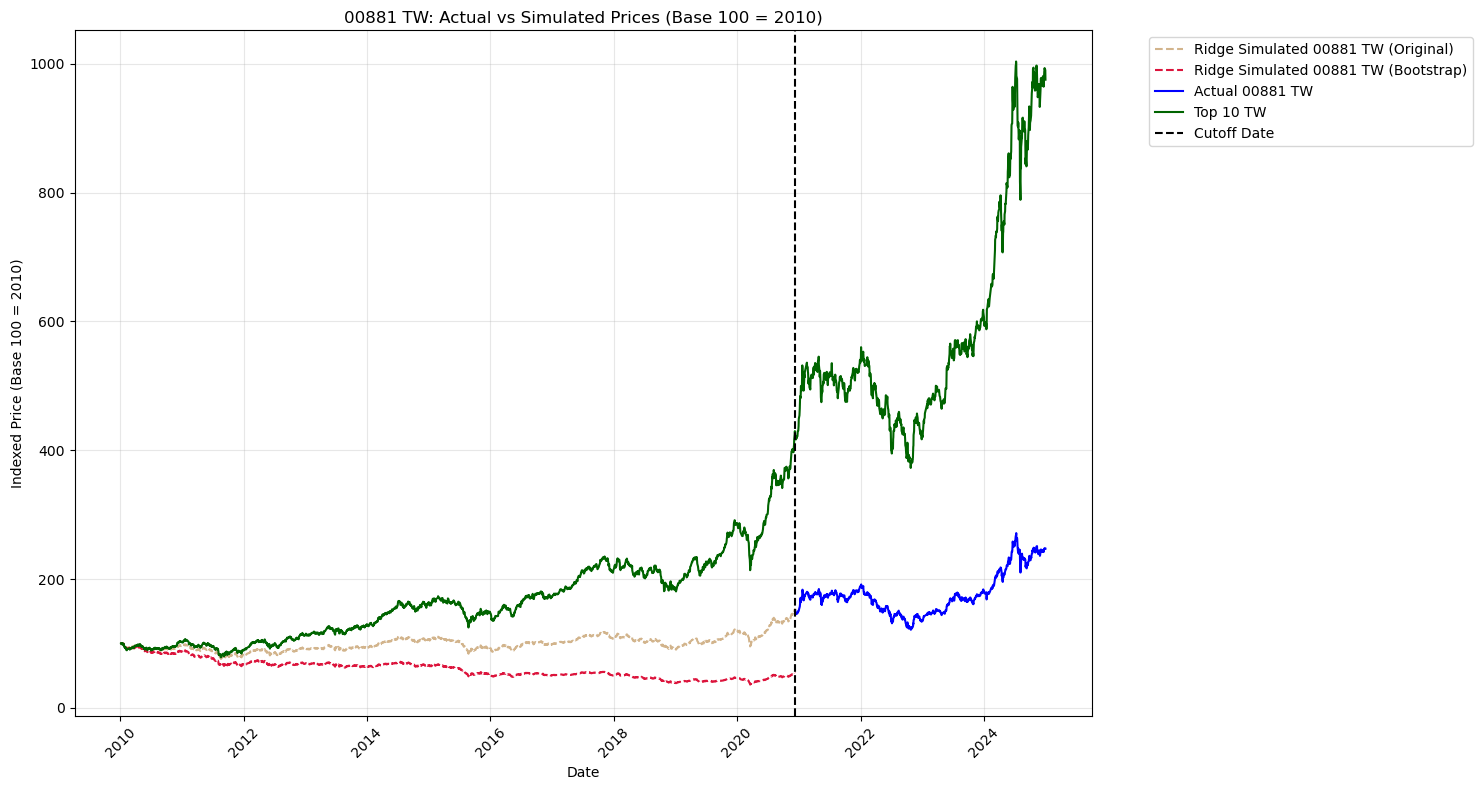


Base Values (2010):
Top 10 TW Base Value: 100.00
Simulation Value at Cutoff: 151.81


In [11]:
#Create the plot
plt.figure(figsize=(15, 8))

plt.plot(historical_returns.index, indexed_sim_original, color='tan',
         label='Ridge Simulated 00881 TW (Original)', linestyle='--')
plt.plot(historical_returns.index, indexed_sim_boot, color='crimson',
         label='Ridge Simulated 00881 TW (Bootstrap)', linestyle='--')
plt.plot(df_00881.index, indexed_actual_00881, color='blue',
         label='Actual 00881 TW')
plt.plot(indexed_top10.index, indexed_top10, color='darkgreen',
         label='Top 10 TW')

plt.axvline(x=pd.to_datetime(cutoff_date), color='black', linestyle='--',
           label='Cutoff Date')

plt.title('00881 TW: Actual vs Simulated Prices (Base 100 = 2010)')
plt.xlabel('Date')
plt.ylabel('Indexed Price (Base 100 = 2010)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print base values for verification
print("\nBase Values (2010):")
print(f"Top 10 TW Base Value: {base_value_top10:.2f}")
print(f"Simulation Value at Cutoff: {sim_value_at_cutoff:.2f}")

# Create export DataFrame
export_df = pd.DataFrame(index=historical_returns.index)
export_df['Ridge Simulated 00881 TW (Original)'] = indexed_sim_original
export_df['Ridge Simulated 00881 TW (Bootstrap)'] = indexed_sim_boot
export_df = export_df.join(pd.DataFrame({'Top 10 TW': indexed_top10}))
export_df = export_df.join(pd.DataFrame({'Actual 00881 TW': indexed_actual_00881}))

# Export to CSV
export_df.to_csv('indexed_prices_00881.csv')